# Correlation tests for selected indicators
1. GDP Test

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress, t, combine_pvalues

In [95]:
# Load the data
file_path = "long_formatted_data.csv"

# Load the data from the CSV file
data = pd.read_csv(file_path)
Dependent_variable_code = "SP.DYN.LE00.IN" # Code for Life expectancy

# Get the highest scoring indicators

In [96]:
# Filter dependent and independent variable data
dependent_data = data[data["Indicator Code"] == Dependent_variable_code]
independent_data = data[data["Indicator Code"] != Dependent_variable_code]

# Merge all independent variables with dependent variable data
merged_data = pd.merge(
    dependent_data,
    independent_data,
    on=["Country Code", "Year"],
    suffixes=("_dependent", "_independent")
)

# Ensure that the relevant columns exist
if "Indicator Code_independent" not in merged_data.columns:
    raise KeyError("The 'Indicator Code_independent' column is missing.")

# Drop rows with missing values in dependent and independent values
merged_data = merged_data.dropna(subset=["Value_dependent", "Value_independent"])

# Define a function to compute correlation, R-squared, p-val, and sample size
def compute_stats(group):
    # Extract the dependent and independent values
    x = group["Value_independent"]
    y = group["Value_dependent"]

    # Compute the correlation coefficient, R-squared, and p-value
    corr = np.corrcoef(x, y)[0, 1]
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    r_squared = r_value ** 2

    # Compute the sample size
    n = len(x)

    # Return the computed statistics
    return pd.Series({
        "Correlation Coefficient": corr,
        "R-squared": r_squared,
        "P-value": p_value,
        "Confidence Interval 95%": [slope - 1.96 * std_err, slope + 1.96 * std_err],
        "N": n
    })

# Group by the correct column name and apply the function
results = merged_data.groupby("Indicator Code_independent").apply(compute_stats).reset_index()
results.rename(columns={"Indicator Code_independent": "Indicator Code"}, inplace=True)

# sort results on descending order of R-squared and correlation coefficient, sample size and ascending order of p-value
results = results.sort_values(
    by=["R-squared", "Correlation Coefficient", "N", "P-value"],
    ascending=[False, False, False, True]
)

# print the top 50 results
# remove any duplicate variants of the same indicator (first three parts (seperated by .) match, e.g. SP.DYN.LE00.IN and SP.DYN.LE00.FE.IN)
# save it in top50_results

# Extract a copy of the relevant column and work on it
results_copy = results.copy()

# Extract the first three parts of the "Indicator Code"
results_copy["Indicator Key"] = results_copy["Indicator Code"].str.extract(r"^([^.]+\.[^.]+\.[^.]+)")

# Remove duplicates based on the extracted "Indicator Key"
unique_results = results_copy.drop_duplicates(subset="Indicator Key")

# Select the top 20 results
top20_results = unique_results[["Indicator Code", "Correlation Coefficient", "R-squared", "N", "P-value"]].head(40)

# load indicator names and codes
indicator_codes = pd.read_csv("indicator_name_and_code.csv")


independent_variables_ranking_list = unique_results[["Indicator Code", "Correlation Coefficient", "R-squared", "N", "P-value"]]

independent_variables_ranking_list = pd.merge(independent_variables_ranking_list, indicator_codes, on="Indicator Code")

independent_variables_ranking_list = independent_variables_ranking_list[["Indicator Name", "Indicator Code", "Correlation Coefficient", "R-squared", "N", "P-value"]] = independent_variables_ranking_list[["Indicator Name", "Indicator Code", "Correlation Coefficient", "R-squared", "N", "P-value"]]

# merge indicator names with top50_results
top20_results = pd.merge(top20_results, indicator_codes, on="Indicator Code")

# move the indicator name column to the first
top20_results = top20_results[["Indicator Name", "Indicator Code", "Correlation Coefficient", "R-squared", "N", "P-value"]]
# Print the top 50 results
print(top20_results)

                                       Indicator Name     Indicator Code  \
0            Life expectancy at birth, female (years)  SP.DYN.LE00.FE.IN   
1            Survival to age 65, female (% of cohort)  SP.DYN.TO65.FE.ZS   
2   Mortality rate, adult, female (per 1,000 femal...     SP.DYN.AMRT.FE   
3   Mortality rate, infant, male (per 1,000 live b...  SP.DYN.IMRT.MA.IN   
4   Mortality rate, under-5, male (per 1,000 live ...     SH.DYN.MORT.MA   
5   Human capital index (HCI), lower bound (scale ...     HD.HCI.OVRL.LB   
6   Cause of death, by non-communicable diseases (...     SH.DTH.NCOM.ZS   
7    Mortality rate, neonatal (per 1,000 live births)        SH.DYN.NMRT   
8   Cause of death, by communicable diseases and m...     SH.DTH.COMM.ZS   
9                          UHC service coverage index  SH.UHC.SRVS.CV.XD   
10  Probability of dying among youth ages 20-24 ye...        SH.DYN.2024   
11  Prevalence of anemia among children (% of chil...     SH.ANM.CHLD.ZS   
12  Probabil

C:\Users\Victor\AppData\Local\Temp\ipykernel_5528\2763407824.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = merged_data.groupby("Indicator Code_independent").apply(compute_stats).reset_index()


# Plot the indicators in heatmap

Indicator Name              object
Indicator Code              object
Correlation Coefficient    float64
R-squared                  float64
N                            int64
P-value                    float64
dtype: object


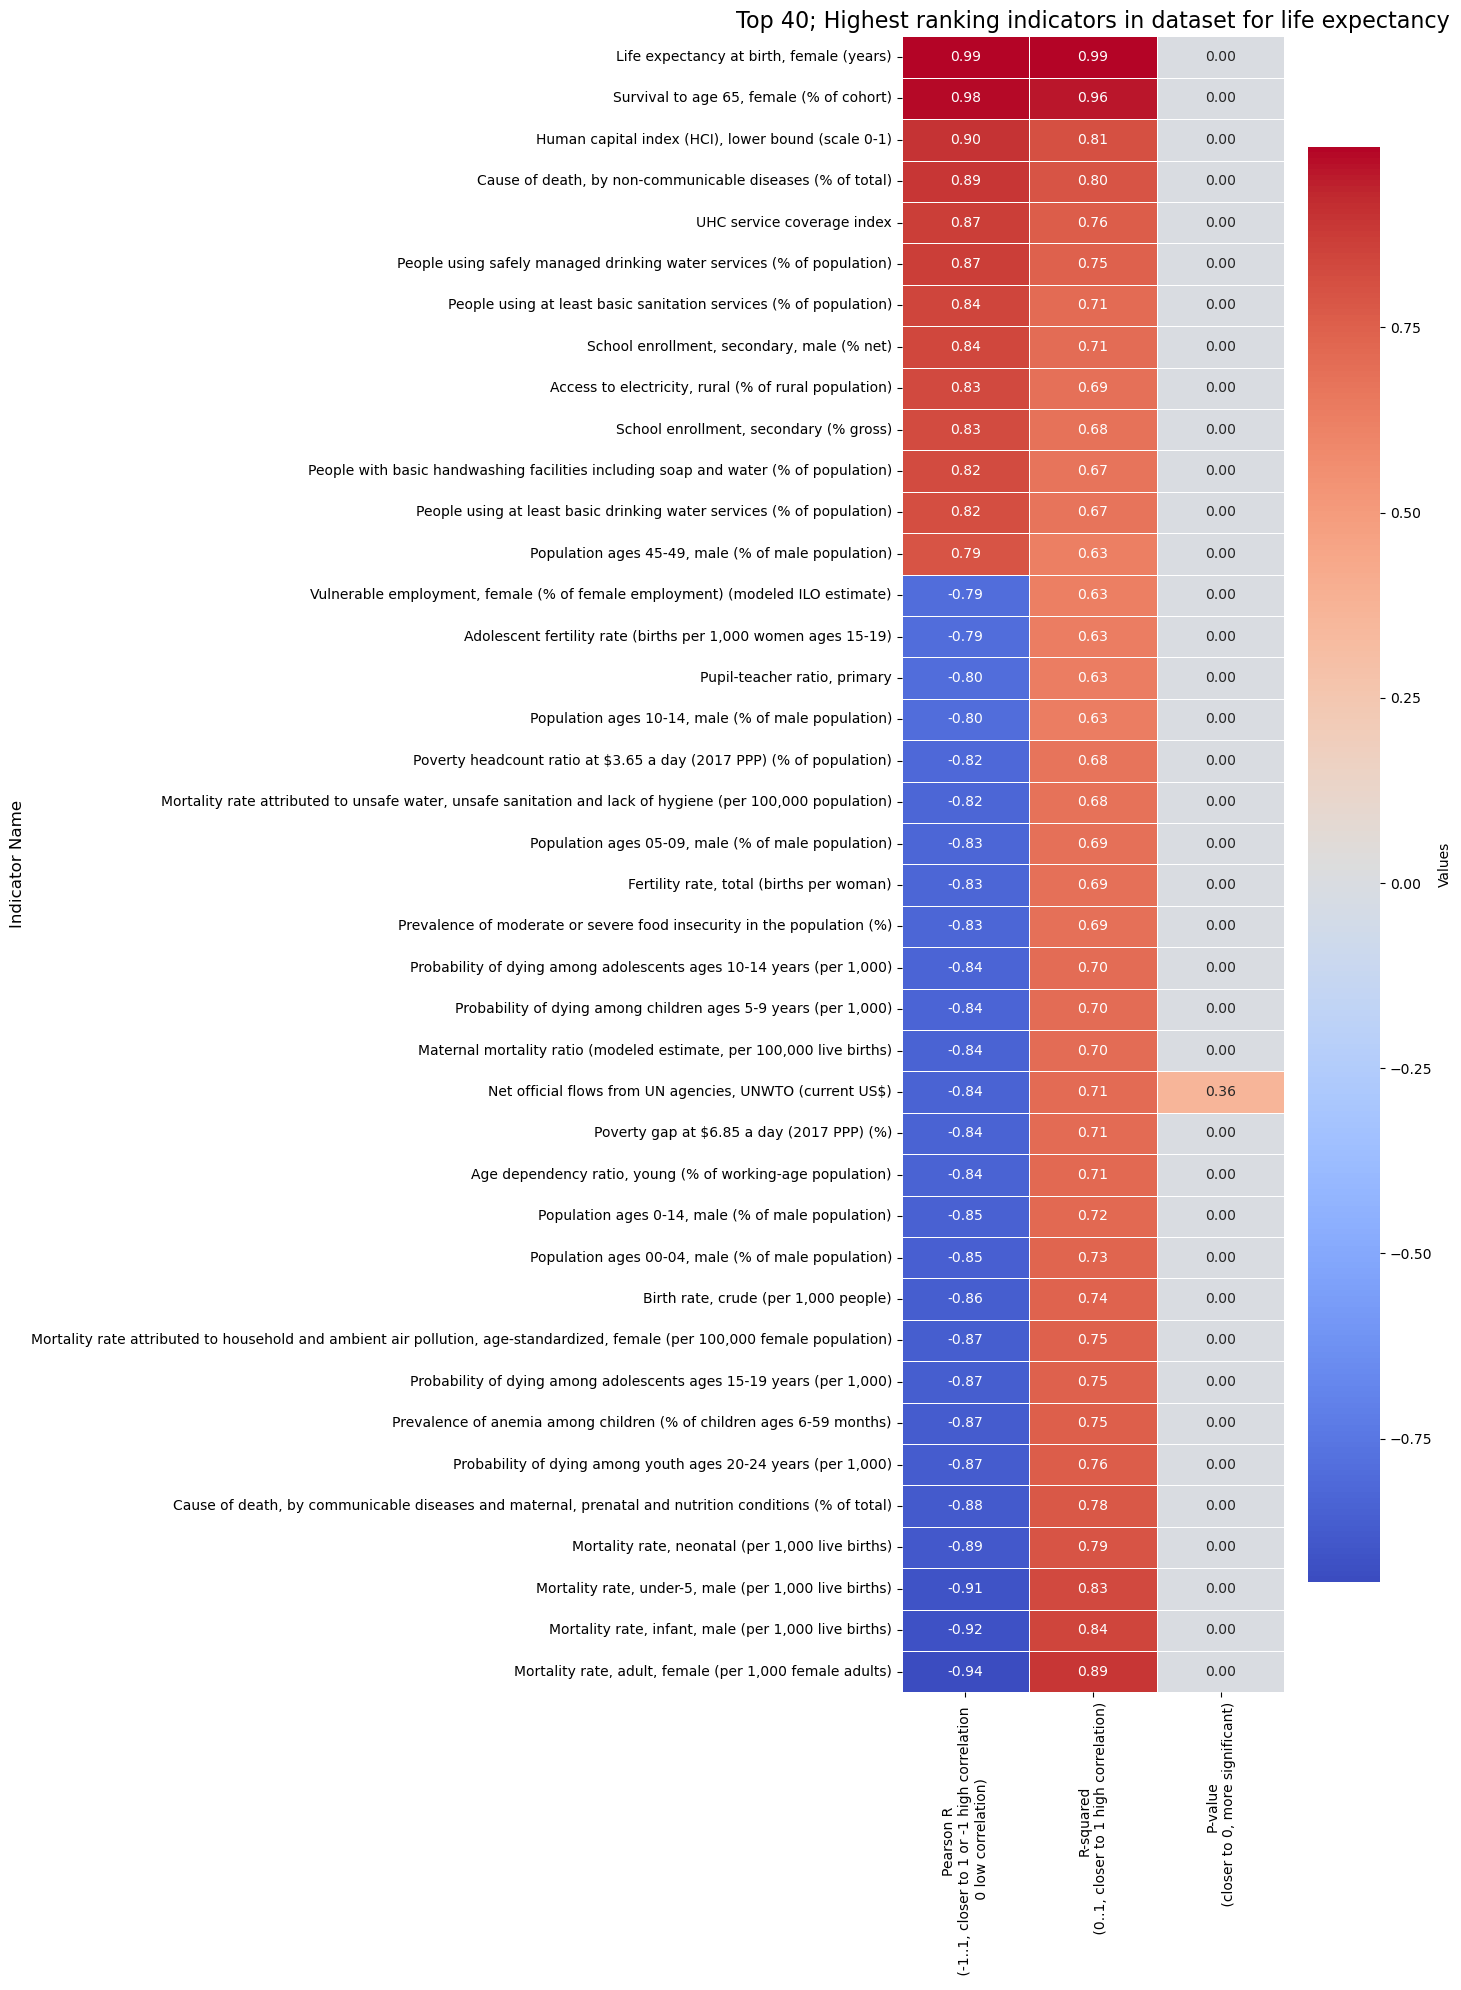

In [62]:
import seaborn as sns

df = pd.DataFrame(top20_results)
print(df.dtypes)

df.drop(columns=["Indicator Code"], inplace=True)
df.drop(columns=["N"], inplace=True)
# sort the dataframe based on R-squared and correlation coefficient
df = df.sort_values(by="R-squared", ascending=False).reset_index(drop=True)
# Melt the DataFrame to long format for heatmap
df_melted = df.melt(id_vars=['Indicator Name'], var_name='Metric', value_name='Values')

# Create a pivot table for the heatmap
heatmap_data = df_melted.pivot(index='Indicator Name', columns='Metric', values='Values')
heatmap_data = heatmap_data.loc[
    df.sort_values(by=['Correlation Coefficient'], ascending=[False])['Indicator Name']
]

# move the p-value column to the last column
heatmap_data = heatmap_data[
    ['Correlation Coefficient', 'R-squared', 'P-value']]

# rename Correlation Coefficient to Pearson R
heatmap_data.rename(columns={"Correlation Coefficient": "Pearson R\n (-1..1, closer to 1 or -1 high correlation \n 0 low correlation)"}, inplace=True)
heatmap_data.rename(columns={"R-squared": "R-squared\n (0..1, closer to 1 high correlation)"}, inplace=True)
heatmap_data.rename(columns={"P-value": "P-value\n (closer to 0, more significant)"}, inplace=True)

# Plotting the heatmap
plt.figure(figsize=(14, 20))  # Adjust figure size
sns.heatmap(
    heatmap_data,
    cmap='coolwarm',
    annot=True,
    fmt='.2f',
    linewidths=0.5,
    cbar_kws={'label': 'Values'},
    annot_kws={"size": 10}  # Adjust annotation size
)


# Add title and labels
plt.title('Top 40; Highest ranking indicators in dataset for life expectancy', fontsize=16)
plt.xlabel('')
plt.ylabel('Indicator Name', fontsize=12)
# Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha='center')
plt.tight_layout()

plt.show()

# Limited set of variables plotting pt 1

In [97]:
variables_chosen_for_analysis = ["SH.DTH.NCOM.ZS", # Cause of death, by non-communicable diseases (% of total)
"SH.DTH.COMM.ZS", # Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)
"SH.DYN.1519", # Probability of dying among adolescents ages 15-19 years (per 1,000)
"SH.DYN.0509", # Probability of dying among children ages 5-9 years (per 1,000)
"SH.STA.MMRT", # Maternal mortality ratio (per 100,000 live births)
"SH.DYN.MORT.MA", # Mortality rate, under-5, male (per 1,000 live births)
"SP.DYN.AMRT.FE", # Mortality rate, adult, female (per 1,000 female adults)
"SH.ANM.CHLD.ZS", # Prevalence of anemia among children (% of children ages 6-59 months)
"SN.ITK.MSFI.ZS", #  Prevalence of moderate or severe food insecurity in the population (%)
"SH.UHC.SRVS.CV.XD", # UHC service coverage index

"HD.HCI.OVRL.LB", # Human capital index (HCI), lower bound (scale 0-1)
"SE.SEC.NENR.MA", # School enrollment, secondary, male (% net)

"SP.POP.0014.MA.ZS", # Population ages 0-14, male (% of male population)
"SP.POP.DPND.YG", # Age dependency ratio, young (% of working-age population)
"SP.DYN.TFRT.IN", # Fertility rate, total (births per woman)


"SH.H2O.SMDW.ZS", # People using safely managed drinking water services (% of population)
"SH.STA.BASS.ZS", # People using at least basic sanitation services (% of population)
"EG.ELC.ACCS.RU.ZS", # Access to electricity, rural (% of rural population)
"SH.STA.AIRP.FE.P5" # Mortality rate attributed to household and ambient air pollution, age-standardized, female (per 100,000 female population)
]

# add it to dataframe
seperate_analysis_df = pd.DataFrame({"Indicator Code": variables_chosen_for_analysis})

# merge with indicator names
seperate_analysis_df = pd.merge(seperate_analysis_df, indicator_codes, on="Indicator Code")

# merge with data for the chosen indicators
seperate_analysis_df = pd.merge(seperate_analysis_df, results, on="Indicator Code")

# get the number of countries by counting the number of unique country codes for each indicator
seperate_analysis_df["Number of Countries"] = data.groupby("Indicator Code")["Country Code"].nunique().loc[variables_chosen_for_analysis].values

# calculate the average sample size for each indicator
seperate_analysis_df["Average N samples"] = data.groupby("Indicator Code")["Value"].count().loc[variables_chosen_for_analysis].values / seperate_analysis_df["Number of Countries"]

# round the r-sq, r values and ci95% to 2 decimal places
seperate_analysis_df["R-squared"] = seperate_analysis_df["R-squared"].round(2)
seperate_analysis_df["Correlation Coefficient"] = seperate_analysis_df["Correlation Coefficient"].round(2)
seperate_analysis_df["Confidence Interval 95%"] = seperate_analysis_df["Confidence Interval 95%"].apply(lambda x: [round(x[0], 2), round(x[1], 2)])



In [125]:
from scipy.optimize import curve_fit
plot_analysis_indicators = [
"SH.DYN.1519", # Probability of dying among adolescents ages 15-19 years (per 1,000)
"SH.DYN.0509", # Probability of dying among children ages 5-9 years (per 1,000)
"SH.DYN.MORT.MA", # Mortality rate, under-5, male (per 1,000 live births)
"SP.DYN.AMRT.FE", # Mortality rate, adult, female (per 1,000 female adults)
"SH.STA.MMRT", # Maternal mortality ratio (per 100,000 live births)
"SH.ANM.CHLD.ZS", # Prevalence of anemia among children (% of children ages 6-59 months)

"SP.POP.0014.MA.ZS", # Population ages 0-14, male (% of male population)
"SP.POP.DPND.YG", # Age dependency ratio, young (% of working-age population)
"SP.DYN.TFRT.IN", # Fertility rate, total (births per woman)


"SH.H2O.SMDW.ZS", # People using safely managed drinking water services (% of population)
"SH.STA.BASS.ZS", # People using at least basic sanitation services (% of population)
"EG.ELC.ACCS.RU.ZS", # Access to electricity, rural (% of rural population)
]

plot_units = [
    "per 1,000 inhabitants",
    "per 1,000 inhabitants",
    "per 1,000 live births",
    "per 1,000 female adults",
    "per 100,000 live births",
    "% of children ages 6-59 months",
    "% of male population",
    "% of working-age population",
    "births per woman",
    "% of population",
    "% of population",
    "% of rural population"
]

trendlines =[
    "log",
    "log",
    "lin",
    "log",
    "exp",
    "lin",
    "lin",
    "lin",
    "lin",
    "log",
    "log",
    "log"
]
# plot the analysis indicators against life expectancy
fig, axs = plt.subplots(3, 4, figsize=(20, 15))
def exponential(x, a, b):
  return a * np.exp(b * x)

for i, indicator in enumerate(plot_analysis_indicators):
    ax = axs[i // 4, i % 4]
    sns.scatterplot(
        data=merged_data[merged_data["Indicator Code_independent"] == indicator],
        x="Value_independent",
        y="Value_dependent",
        ax=ax
    )
    ax.set_title(indicator_codes[indicator_codes["Indicator Code"] == indicator]["Indicator Name"].values[0])
    ax.set_xlabel(plot_units[i])
    ax.set_ylabel("Life Expectancy (years at birth)")
    # fit lin or log trendline
    if(trendlines[i] == "lin"):
        # add line to existing plot
        x = merged_data[merged_data["Indicator Code_independent"] == indicator]["Value_independent"]
        y = merged_data[merged_data["Indicator Code_independent"] == indicator]["Value_dependent"]
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        ax.plot(x, slope * x + intercept, color='red')
    elif(trendlines[i] == "log"):
       x = merged_data[merged_data["Indicator Code_independent"] == indicator]["Value_independent"]
       y = merged_data[merged_data["Indicator Code_independent"] == indicator]["Value_dependent"]
       df = pd.merge(pd.DataFrame(x), pd.DataFrame(y), left_index=True, right_index=True)
       df.columns = ['x', 'y']
       df = df[df['x'] > 0]  # Filter out non-positive values to avoid issues with log
       df.sort_values(by='x', inplace=True)
       
       # Apply log transformation to x
       df['log_x'] = np.log(df['x'])
       
       # Perform linear regression on log-transformed 
       slope, intercept, r_value, p_value, std_err = linregress(df["log_x"], df["y"])
              
       # Plot the trendline, converting log_x back to the original scale for plotting
       x_fit = np.linspace(df['x'].min(), df['x'].max(), 100)
       
       log_x_fit = np.log(x_fit)
       
       y_fit = slope * log_x_fit + intercept
       ax.plot(x_fit, y_fit, color='red')
    elif(trendlines[i] == "exp"):
       x = merged_data[merged_data["Indicator Code_independent"] == indicator]["Value_independent"]
       y = merged_data[merged_data["Indicator Code_independent"] == indicator]["Value_dependent"]
       df = pd.merge(pd.DataFrame(x), pd.DataFrame(y), left_index=True, right_index=True)
       df.columns = ['x', 'y']
       df.sort_values(by='x', inplace=True)
       popt, _ = curve_fit(exponential, df['x'], df['y'],  p0=[-0.5, -0.1])
       a, b = popt
       ax.plot(df['x'], exponential(df['x'], a, b), color='red')

       

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

: 

: 

# Select the indicator to test

In [3]:
Independent_variable_code = "NY.GDP.PCAP.CD" # Code for GDP

Independent_variable_name = "GDP per capita"
Independent_variable_short_name = "GDP"
Independent_variable_unit = "USD"

# GDP Test
1. Get the correlation & R^2 value against life expectancy
2. Fit linear regression
3. Get p-val, residuals & confidence interval (95%)
4. Create scatterplot
5. Create plot of residuals

In [80]:

# Get all raw data for the dependent variable
LE_data = data[data["Indicator Code"] == Dependent_variable_code]
# Get all raw data for the independent variable
GDP_data = data[data["Indicator Code"] == Independent_variable_code]

# Join the LE_data and GDP_data on the "Country Code" and "Year" columns
# This makes sure that we have GDP and LE data for the same country and year
GDP_joined_data = pd.merge(GDP_data, LE_data, on=["Country Code", "Year"])

# Drop rows with missing values
# This is necessary because the scatter plot function does not work with missing values
GDP_joined_data = GDP_joined_data.dropna()

# Create array from this data frame in x, y format
# x is GDP per capita
# y is Life expectancy
x = GDP_joined_data["Value_x"]
y = GDP_joined_data["Value_y"]



# Fit Linear Regression and get correlation coefficient, r-squared, p-value, residuals and confidence intervals
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calculate the R-squared value
r_squared = r_value**2


# Calculate degrees of freedom
n = len(x)
df = n - 2

# Critical t-value for 95% confidence level
confidence = 0.95
alpha = 1 - confidence
t_critical = t.ppf(1 - alpha / 2, df)

# Margin of error
margin_of_error = t_critical * std_err

# Confidence interval for the slope
slope_ci_lower = slope - margin_of_error
slope_ci_upper = slope + margin_of_error


# Print the results
print("Slope: ", slope)
print("Intercept: ", intercept)
print("R-squared: ", r_squared)
print("R-value: ", r_value)
print("P-value: ", p_value)
print("Standard error: ", std_err)
print("95% Confidence Interval for Slope: ({:.6f}, {:.6f})".format(slope_ci_lower, slope_ci_upper))


# Scatter plot with smaller dot size (s=5)
plt.scatter(x, y, s=5)
plt.xlabel(Independent_variable_name +"(" + Independent_variable_unit + ")")
plt.ylabel("Life expectancy")
plt.title("Life expectancy vs "+Independent_variable_name)
plt.show()


# Scatter plot with linear regression line
plt.scatter(x, y, s=5)
plt.plot(x, slope*x + intercept, color="red")
plt.xlabel(Independent_variable_name +"(" + Independent_variable_unit + ")")
plt.ylabel("Life expectancy (Years)")
plt.title("Life expectancy vs "+Independent_variable_name)
plt.show()

# Plot the residuals in histogram, show some lines between the bars
residuals = y - (slope*x + intercept)
plt.hist(residuals, bins=30, edgecolor="black")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of "+Independent_variable_short_name+" residuals")
plt.show()

# Log transformation of x (GDP per capita)
log_x = np.log(x)

# Fit log-linear regression
slope_log, intercept_log, r_value_log, p_value_log, std_err_log = linregress(log_x, y)

# Calculate R-squared for log regression
r_squared_log = r_value_log**2

# Calculate degrees of freedom
n = len(x)
df_log = n - 2

# Critical t-value for 95% confidence level
confidence = 0.95
alpha = 1 - confidence
t_critical_log = t.ppf(1 - alpha / 2, df_log)

# Margin of error for slope
margin_of_error_log = t_critical_log * std_err_log

# Confidence interval for the slope
slope_ci_lower_log = slope_log - margin_of_error_log
slope_ci_upper_log = slope_log + margin_of_error_log

# Print the regression results
print("Slope (log): ", slope_log)
print("Intercept (log): ", intercept_log)
print("R-squared (log): ", r_squared_log)
print("R-value (log): ", r_value_log)
print("P-value (log): ", p_value_log)
print("Standard error (log): ", std_err_log)
print("95% Confidence Interval for Slope (log): ({:.6f}, {:.6f})".format(slope_ci_lower_log, slope_ci_upper_log))

sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]

# Plot scatter plot and single clean regression line
plt.scatter(x, y, s=5)
plt.plot(x_sorted, slope_log * np.log(x_sorted) + intercept_log, color="red")
plt.xlabel(Independent_variable_name +"(" + Independent_variable_unit + ")")
plt.ylabel("Life expectancy")
plt.title("Life expectancy vs "+Independent_variable_name+" (log)")
plt.show()


print("Number of countries: ",len(np.unique(GDP_data["Country Code"])))

NameError: name 'Independent_variable_code' is not defined

# P-value distribution

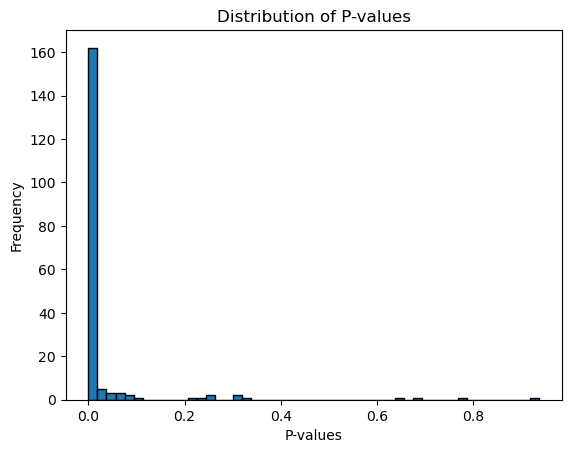

Combined p-value:  0.0


In [23]:
# for each country calculate the p-value
p_values = []
for country in GDP_joined_data["Country Code"].unique():
    country_data = GDP_joined_data[GDP_joined_data["Country Code"] == country]
    
    # Drop rows with NaN values in the relevant columns
    country_data = country_data.dropna(subset=["Value_x", "Value_y"])
    
    x = country_data["Value_x"]
    y = country_data["Value_y"]
    
    # Only proceed if there are at least two points and variation in the data
    if len(x) > 1 and len(np.unique(x)) > 1 and len(np.unique(y)) > 1:
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        p_values.append(p_value)
    else:
        p_values.append(np.nan)  # Append NaN if regression can't be performed

# # Filter out NaN and invalid p-values
valid_p_values = [p for p in p_values if 0 < p < 1]
plt.hist(valid_p_values, bins=50, edgecolor='black')
plt.xlabel('P-values')
plt.ylabel('Frequency')
plt.title('Distribution of P-values')
plt.show()
# Combine p-values using Fisher's method
combined_p_value = combine_pvalues(valid_p_values, method="fisher")[1]

# Print the combined p-value
print("Combined p-value: ", combined_p_value)